In [31]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
from matplotlib.patches import Rectangle

### Functions

In [32]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        data_sec = datafile[var]
        dict_var[var] = data_sec[idx]
        
    
    return dict_var

In [33]:
def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,depi,vmax,time,title,cblabel,ylabel):
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,4))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],4)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW],f_lons[lonE-1],4),2))
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')


In [34]:
def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,4))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],4)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')

In [35]:
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

In [36]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

lonW = 215
lonE = 345
latgridi = 300
latgridf = latgridi-1
fmask = mesh.fmask[0, :, latgridi]
tmask = mesh.tmask[0]
    
lons = data.init_lon[(data.final_section != 0)]
    
f_lons = mesh.glamf[0, latgridi]
u_lons = mesh.glamv[0, latgridi]
w_depths = mesh.gdepw_1d

# m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

### Importing Data

In [37]:
##Forwards - Eastern JdF
#Jan
datafas = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafds = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/fordec_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafhsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoVS_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafsjvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
datafrsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosVS_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

#July
datafas07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafds07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/fordec_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafhsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafsjvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafrsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

##Backwards
databvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databas = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backADM_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databds = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backdec_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databsjvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databrsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databhsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')

#July
databvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databas07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backadm_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databds07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backdec_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databsjvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databrsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databhsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')

##Forwards - SJGI
# Jan
datafg1 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf1_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafg2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf2_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafhspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafsjpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafrspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18_PR/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

# Jul
datafg107 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf1_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafg207 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf2_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafhspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafsjpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafrspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

##Backwards
# Jan
databg1 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf1_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databg2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf2_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databhspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databsjpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databrspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backPR_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')

# Jul
databg107 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf1_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databg207 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf2_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databhspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoPR_jul18/back_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
databsjpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcPR_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databrspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosPR_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backPR_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')

data_dict = {'datafvs':data,'datafas':datafas,'datafds':datafds,'datafrsvs':datafrsvs,'datafsjvs':datafsjvs,'datafhsvs':datafhsvs,
             'datafvs07':datafvs07,'datafas07':datafas07,'datafds07':datafds07,'datafrsvs07':datafrsvs07,'datafsjvs07':datafsjvs07,'datafhsvs07':datafhsvs07,
             'databvs':databvs,'databas':databas,'databds':databds,'databrsvs':databrsvs,'databsjvs':databsjvs,'databhsvs':databhsvs,
             'databvs07':databvs07,'databas07':databas07,'databds07':databds07,'databrsvs07':databrsvs07,'databsjvs07':databsjvs07,'databhsvs07':databhsvs07,
             'datafpr':datafpr,'datafg1':datafg1,'datafg2':datafg2,'datafrspr':datafrspr,'datafsjpr':datafsjpr,'datafhspr':datafhspr,
             'datafpr07':datafpr07,'datafg107':datafg107,'datafg207':datafg207,'datafrspr07':datafrspr07,'datafsjpr07':datafsjpr07,'datafhspr07':datafhspr07,
             'databpr':databpr,'databg1':databg1,'databg2':databg2,'databrspr':databrspr,'databsjpr':databsjpr,'databhspr':databhspr,
             'databpr07':databpr07,'databg107':databg107,'databg207':databg207,'databrspr07':databrspr07,'databsjpr07':databsjpr07,'databhspr07':databhspr07,
}

/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'Salinity - Haro to Rosario')

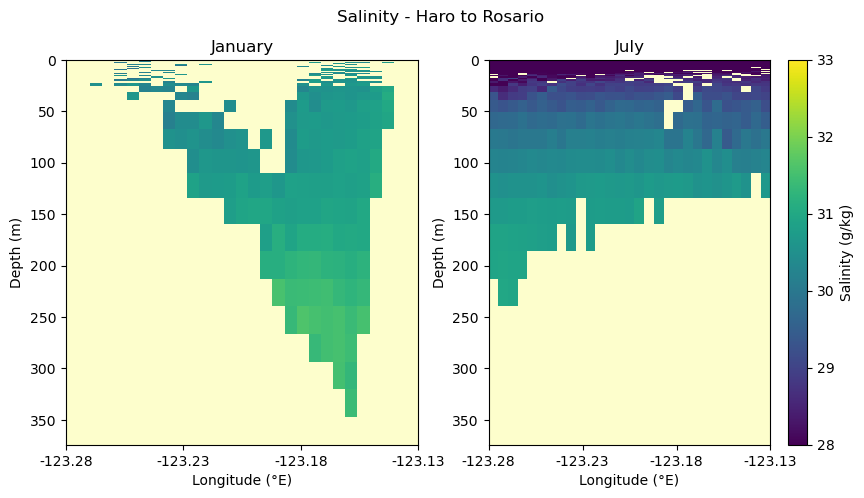

In [38]:
harobrspr = get_secdata(data_dict['databrspr'],6)
harobrspr07 = get_secdata(data_dict['databrspr07'],4)

lonWharo = 215
lonEharo = 245
title = 'January'

title2 = 'July'
time = 168

smin = 28
smax = 33

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax2,'sal',harobrspr07['final_lon'],harobrspr07['final_z'],harobrspr07['final_salt'],lonWharo,lonEharo,38,time,title2,True,True,vmin=smin,vmax=smax)
plotTS(ax1,'sal',harobrspr['final_lon'],harobrspr['final_z'],harobrspr['final_salt'],lonWharo,lonEharo,38,time,title,False,True,vmin=smin,vmax=smax);

fig.suptitle('Salinity - Haro to Rosario')

Saltier deep water from upwelling on WCVI?

/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


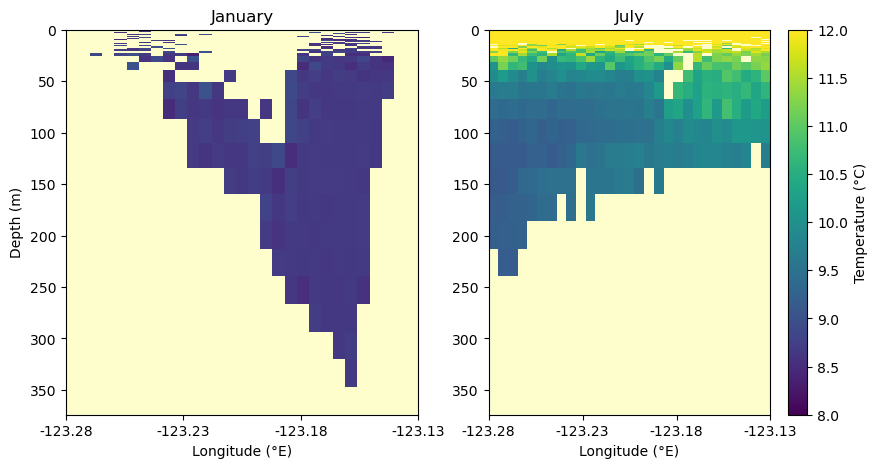

In [39]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

tmin = 8
tmax = 12

plotTS(ax1,'temp',harobrspr['final_lon'],harobrspr['final_z'],harobrspr['final_temp'],lonWharo,lonEharo,38,time,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'temp',harobrspr07['final_lon'],harobrspr07['final_z'],harobrspr07['final_temp'],lonWharo,lonEharo,38,time,title2,True,False,vmin=tmin,vmax=tmax)

/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


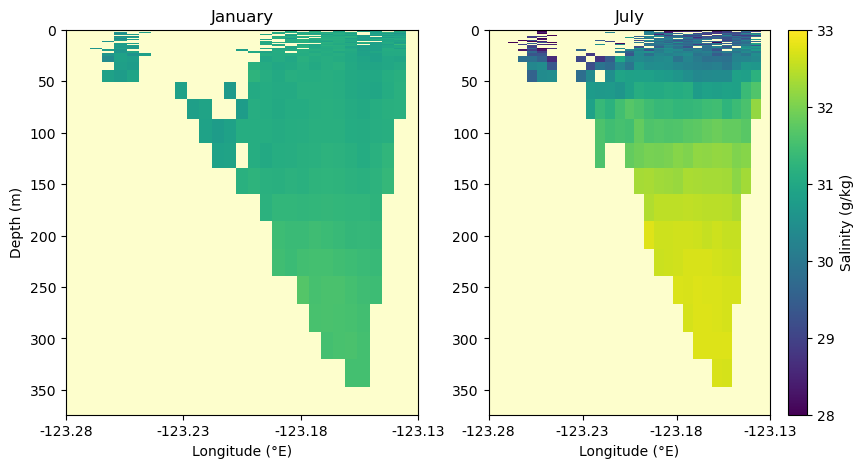

In [40]:
harofvs = get_secdata(data,6)
harofvs07 = get_secdata(datafvs07,6)

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))


plotTS(ax1,'sal',harofvs['final_lon'],harofvs['final_z'],harofvs['final_salt'],lonWharo,lonEharo,38,time,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',harofvs07['final_lon'],harofvs07['final_z'],harofvs07['final_salt'],lonWharo,lonEharo,38,time,title2,True,False,vmin=smin,vmax=smax)

/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


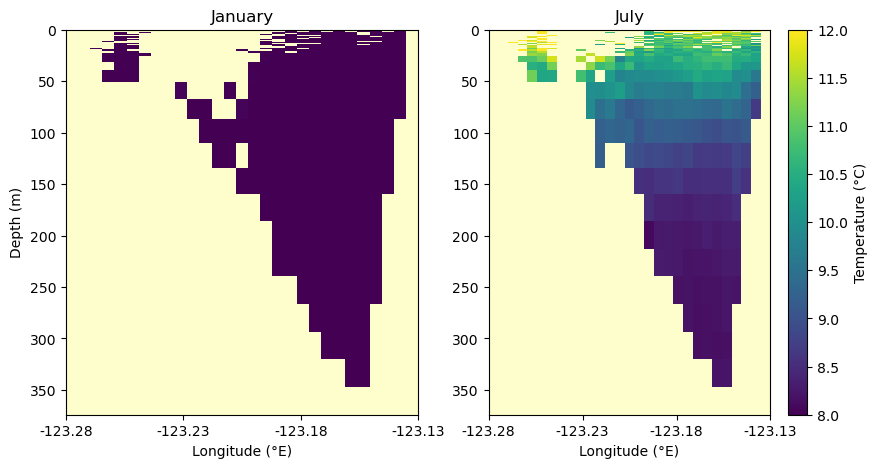

In [41]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax1,'temp',harofvs['final_lon'],harofvs['final_z'],harofvs['final_temp'],lonWharo,lonEharo,38,time,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'temp',harofvs07['final_lon'],harofvs07['final_z'],harofvs07['final_temp'],lonWharo,lonEharo,38,time,title2,True,False,vmin=tmin,vmax=tmax)

More stratified in July

### Rosario Seeding

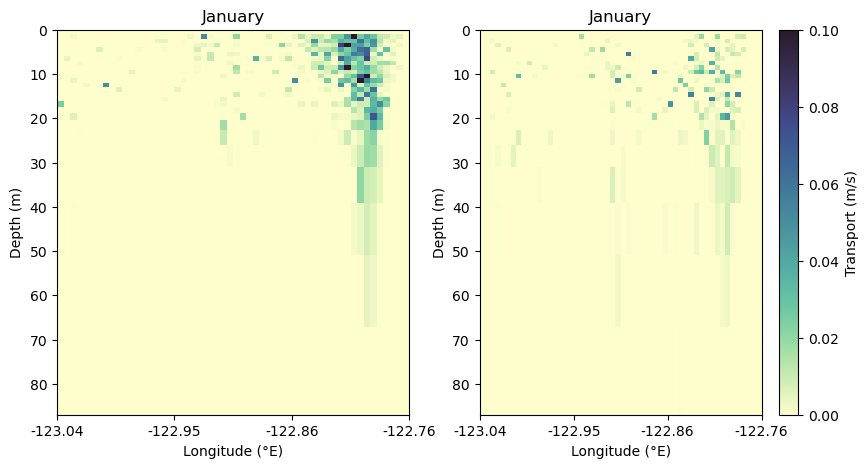

In [42]:
admbrs = get_secdata(databrsvs,2)
admbrs07 = get_secdata(databrsvs07,2)

lonWadm = 260
lonEadm = 315

vmax = 0.1
timeb = 169

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotCS(ax1,admbrs['final_lon'],admbrs['final_z'],admbrs['final_transp'],lonWadm,lonEadm,27,vmax,timeb,title,False,True)
plotCS(ax2,admbrs07['final_lon'],admbrs07['final_z'],admbrs07['final_transp'],lonWadm,lonEadm,27,vmax,timeb,title,True,True)

/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


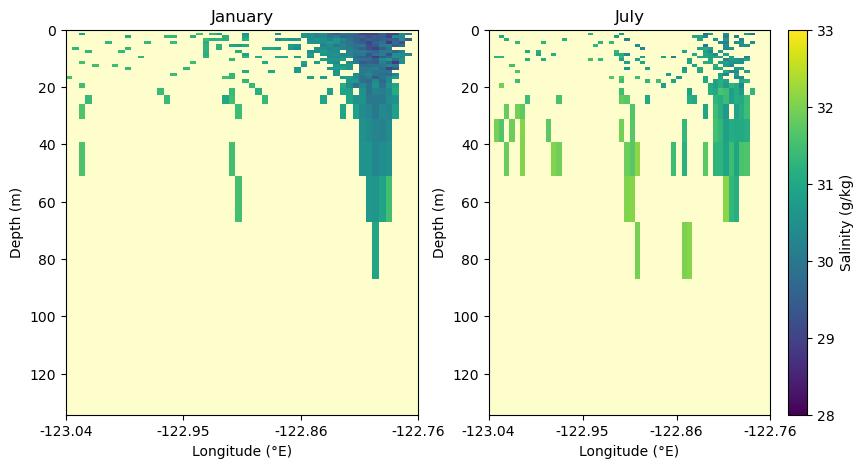

In [43]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax1,'sal',admbrs['final_lon'],admbrs['final_z'],admbrs['final_salt'],lonWadm,lonEadm,29,timeb,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',admbrs07['final_lon'],admbrs07['final_z'],admbrs07['final_salt'],lonWadm,lonEadm,29,timeb,title2,True,True,vmin=smin,vmax=smax)

#### Admiralty to Haro

/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


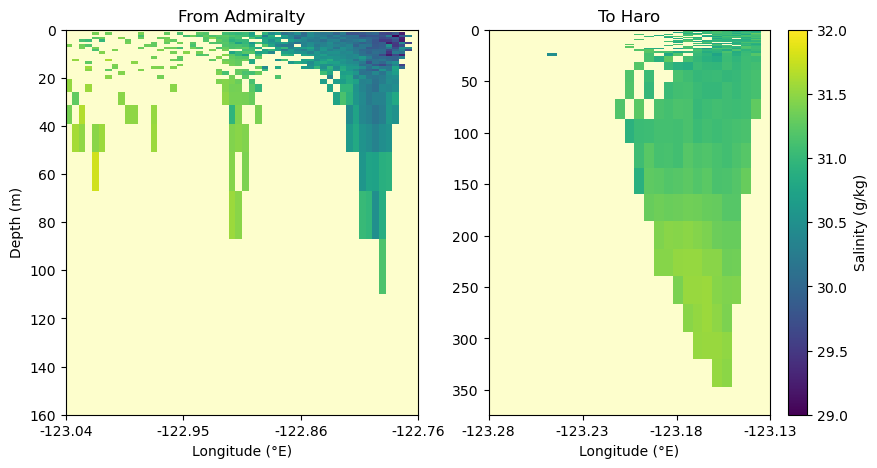

In [44]:
admbhs = get_secdata(databhsvs,2)
harofas = get_secdata(datafas,6)

title = 'To Haro'
title2 = 'From Admiralty'

smin = 29
smax = 32

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax1,'sal',admbhs['final_lon'],admbhs['final_z'],admbhs['final_salt'],lonWadm,lonEadm,30,timeb,title2,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',harofas['final_lon'],harofas['final_z'],harofas['final_salt'],lonWharo,lonEharo,38,time,title,True,False,vmin=smin,vmax=smax)

/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


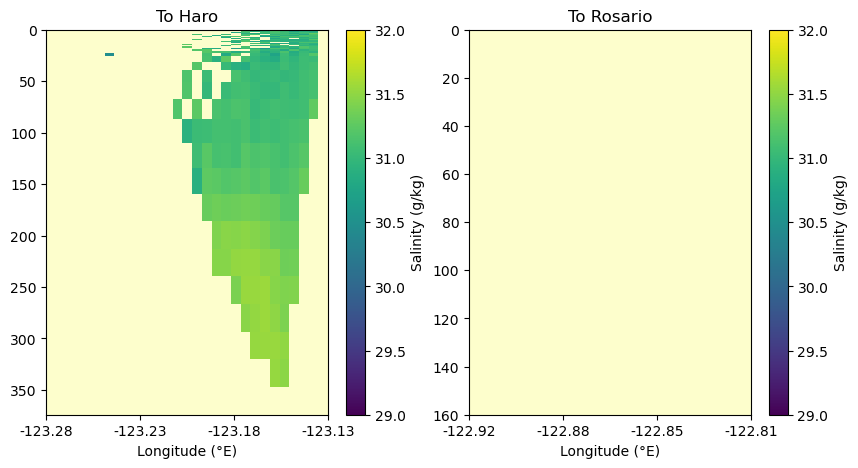

In [45]:
rosfas = get_secdata(datafas,4)
admbrs = get_secdata(databrsvs,2)

lonWros=284
lonEros=305
title = 'To Haro'
title2 = 'To Rosario'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax1,'sal',harofas['final_lon'],harofas['final_z'],harofas['final_salt'],lonWharo,lonEharo,38,time,title,True,False,vmin=smin,vmax=smax)
plotTS(ax2,'sal',rosfas['final_lon'],rosfas['final_z'],rosfas['final_salt'],lonWros,lonEros,30,time,title2,True,False,vmin=smin,vmax=smax)

/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


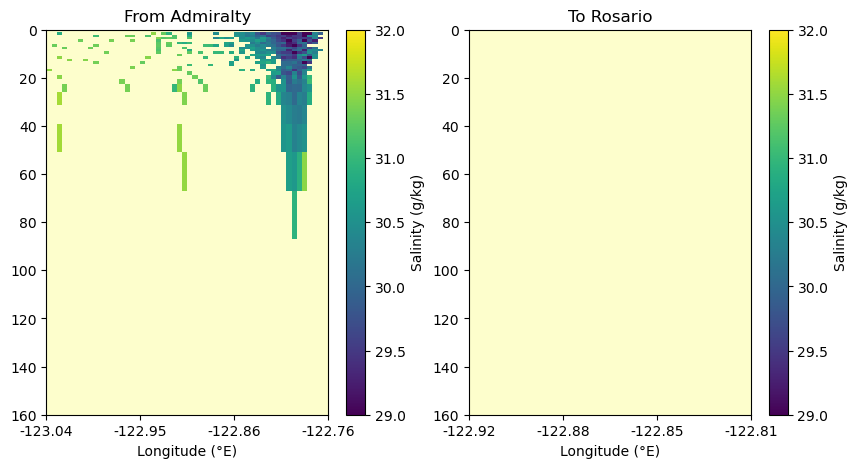

In [46]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

title = 'From Admiralty'
title2 = 'To Rosario'

plotTS(ax1,'sal',admbrs['final_lon'],admbrs['final_z'],admbrs['final_salt'],lonWadm,lonEadm,30,timeb,title,True,False,vmin=smin,vmax=smax)
plotTS(ax2,'sal',rosfas['final_lon'],rosfas['final_z'],rosfas['final_salt'],lonWros,lonEros,30,time,title2,True,False,vmin=smin,vmax=smax)

Fresher entering Rosario than Haro (properties more modified in journey to Haro)

/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'From Admiralty')

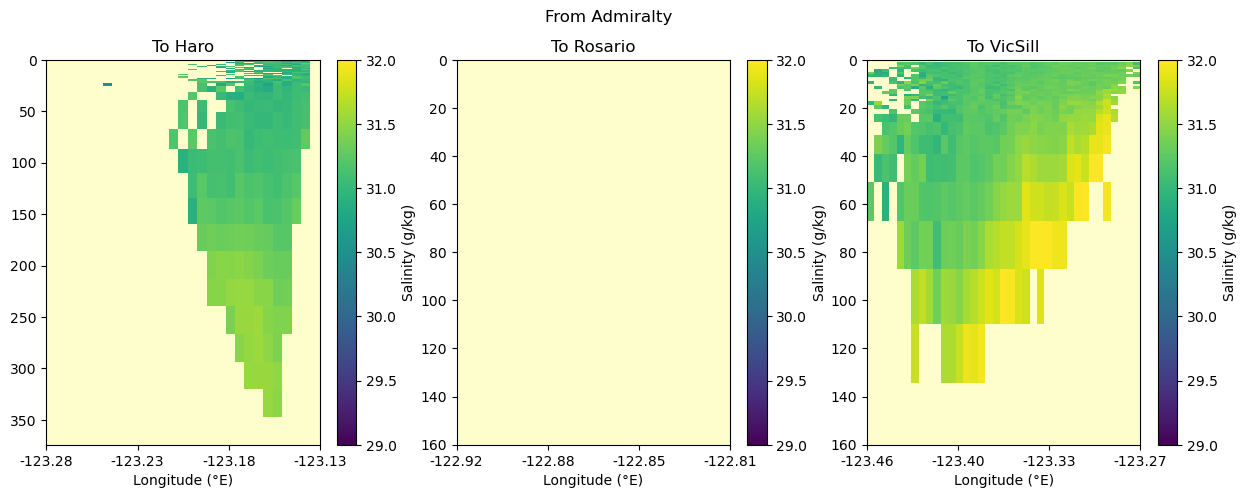

In [47]:
vsfas = get_secdata(datafas,2)
lonWvs = 180
lonEvs = 218

title = 'To Haro'
title2 = 'To Rosario'
title3 = 'To VicSill'

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'sal',harofas['final_lon'],harofas['final_z'],harofas['final_salt'],lonWharo,lonEharo,38,time,title,True,False,vmin=smin,vmax=smax)
plotTS(ax2,'sal',rosfas['final_lon'],rosfas['final_z'],rosfas['final_salt'],lonWros,lonEros,30,time,title2,True,False,vmin=smin,vmax=smax)
plotTS(ax3,'sal',vsfas['final_lon'],vsfas['final_z'],vsfas['final_salt'],lonWvs,lonEvs,30,time,title3,True,False,vmin=smin,vmax=smax)
fig.suptitle('From Admiralty')

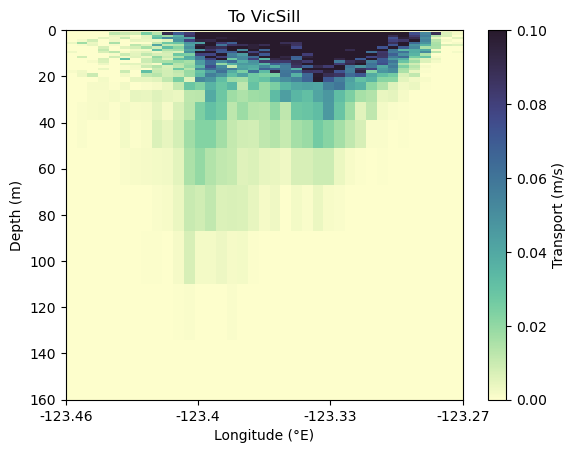

In [48]:
fig,ax = plt.subplots()

title = 'To VicSill'

plotCS(ax,vsfas['final_lon'],vsfas['final_z'],vsfas['final_transp'],lonWvs,lonEvs,30,vmax,time,title,True,True)

/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'Arriving in admiralty')

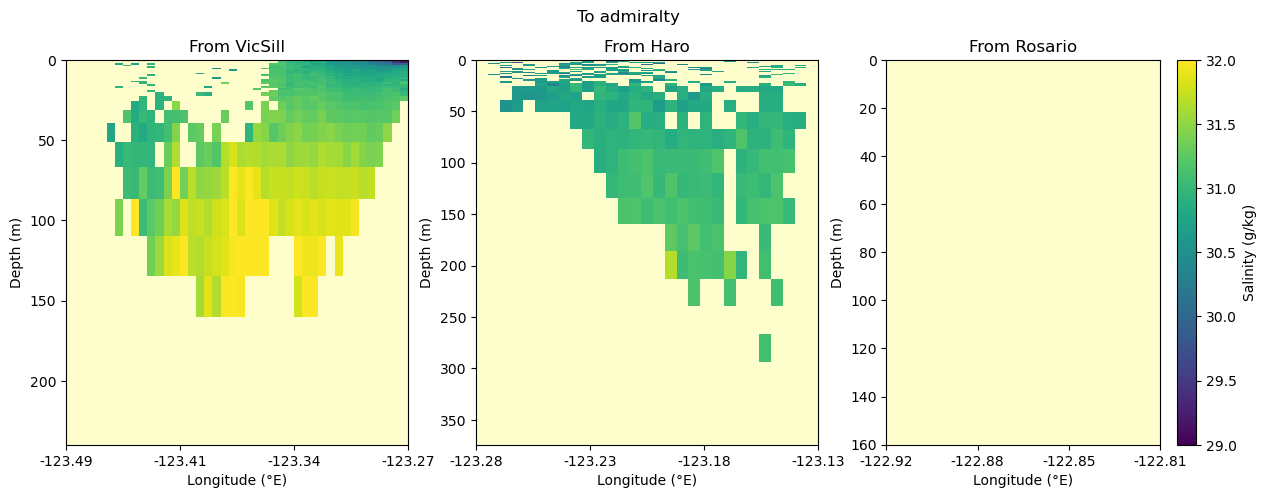

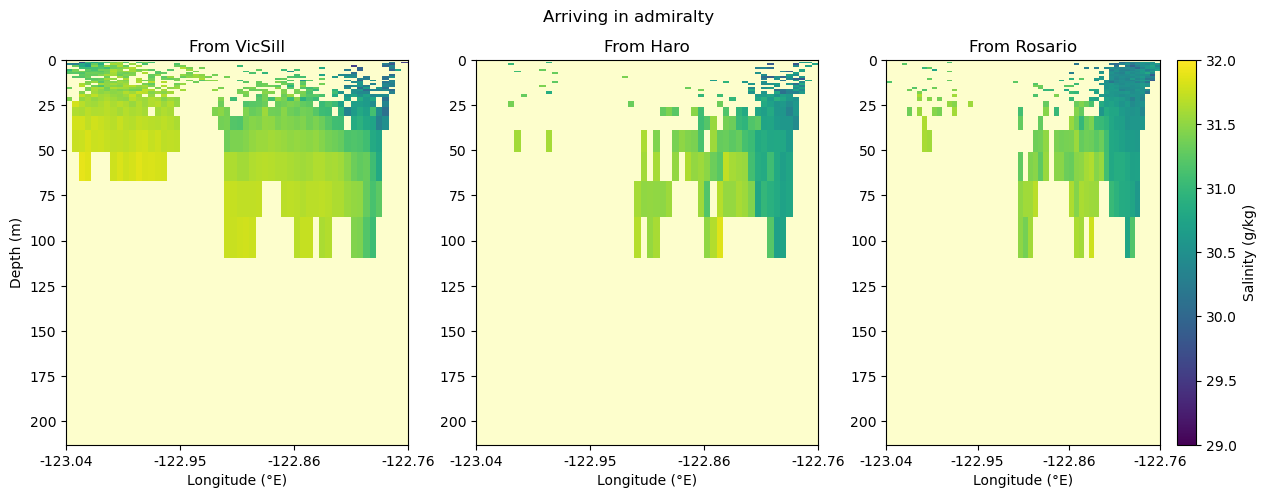

In [49]:
vsbas = get_secdata(databas,2)
harobas = get_secdata(databas,6)
rosbas = get_secdata(databas,4)

admfvs = get_secdata(data,2)
admfhsvs = get_secdata(datafhsvs,2)
admfrsvs = get_secdata(datafrsvs,2)

title = 'From VicSill'
title2 = 'From Haro'
title3 = 'From Rosario'
lonWvs = 175

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'sal',vsbas['final_lon'],vsbas['final_z'],vsbas['final_salt'],lonWvs,lonEvs,33,timeb,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',harobas['final_lon'],harobas['final_z'],harobas['final_salt'],lonWharo,lonEharo,38,timeb,title2,False,True,vmin=smin,vmax=smax)
plotTS(ax3,'sal',rosbas['final_lon'],rosbas['final_z'],rosbas['final_salt'],lonWros,lonEros,30,timeb,title3,True,True,vmin=smin,vmax=smax)
fig.suptitle('To admiralty')

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'sal',admfvs['final_lon'],admfvs['final_z'],admfvs['final_salt'],lonWadm,lonEadm,32,time,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',admfhsvs['final_lon'],admfhsvs['final_z'],admfhsvs['final_salt'],lonWadm,lonEadm,32,time,title2,False,False,vmin=smin,vmax=smax)
plotTS(ax3,'sal',admfrsvs['final_lon'],admfrsvs['final_z'],admfrsvs['final_salt'],lonWadm,lonEadm,32,time,title3,True,False,vmin=smin,vmax=smax)
fig.suptitle('Arriving in admiralty')

#### Summer

/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'Arriving in admiralty')

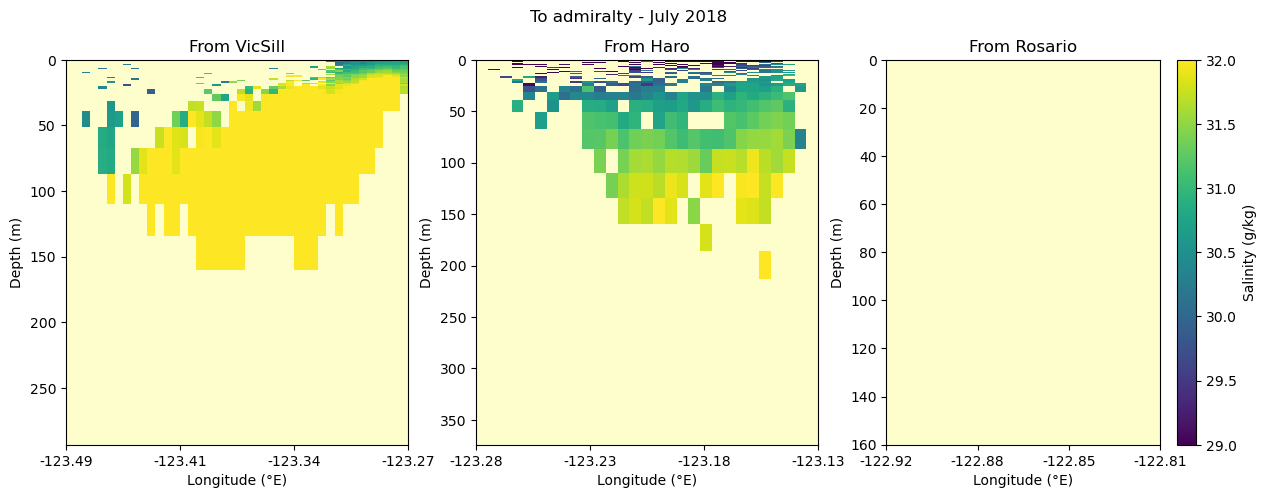

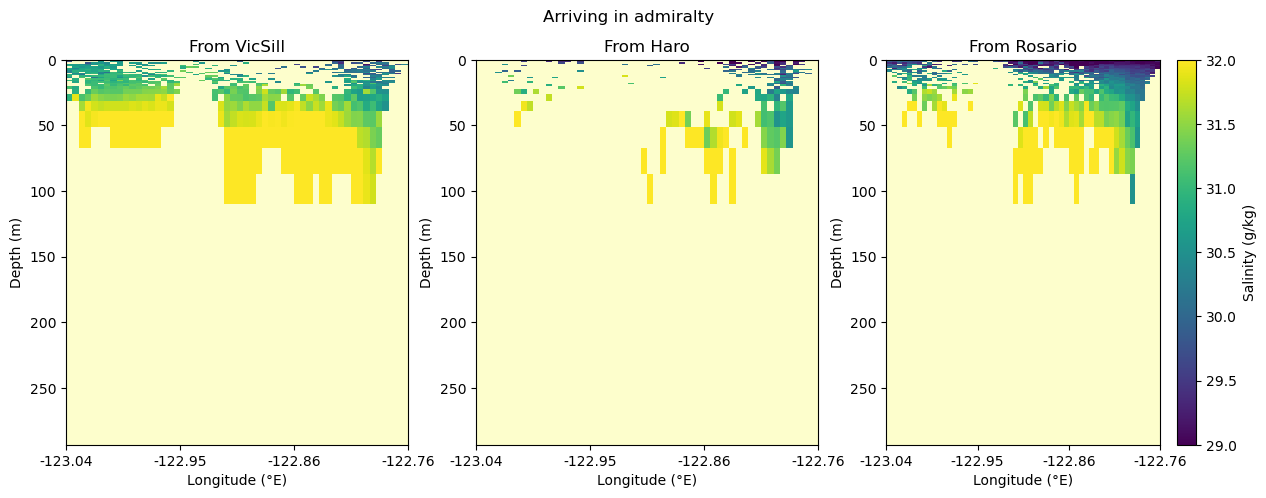

In [50]:
vsbas07 = get_secdata(databas07,2)
harobas07 = get_secdata(databas07,6)
rosbas07 = get_secdata(databas07,4)

admfvs07 = get_secdata(datafvs07,2)
admfhs07 = get_secdata(datafhsvs07,2)
admfrs07 = get_secdata(datafrsvs07,2)

title = 'From VicSill'
title2 = 'From Haro'
title3 = 'From Rosario'

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'sal',vsbas07['final_lon'],vsbas07['final_z'],vsbas07['final_salt'],lonWvs,lonEvs,35,time,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',harobas07['final_lon'],harobas07['final_z'],harobas07['final_salt'],lonWharo,lonEharo,38,time,title2,False,True,vmin=smin,vmax=smax)
plotTS(ax3,'sal',rosbas07['final_lon'],rosbas07['final_z'],rosbas07['final_salt'],lonWros,lonEros,30,time,title3,True,True,vmin=smin,vmax=smax)
fig.suptitle('To admiralty - July 2018')

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'sal',admfvs07['final_lon'],admfvs07['final_z'],admfvs07['final_salt'],lonWadm,lonEadm,35,time,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',admfhs07['final_lon'],admfhs07['final_z'],admfhs07['final_salt'],lonWadm,lonEadm,35,time,title2,False,True,vmin=smin,vmax=smax)
plotTS(ax3,'sal',admfrs07['final_lon'],admfrs07['final_z'],admfrs07['final_salt'],lonWadm,lonEadm,35,time,title3,True,True,vmin=smin,vmax=smax)
fig.suptitle('Arriving in admiralty')

/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'Arriving in admiralty')

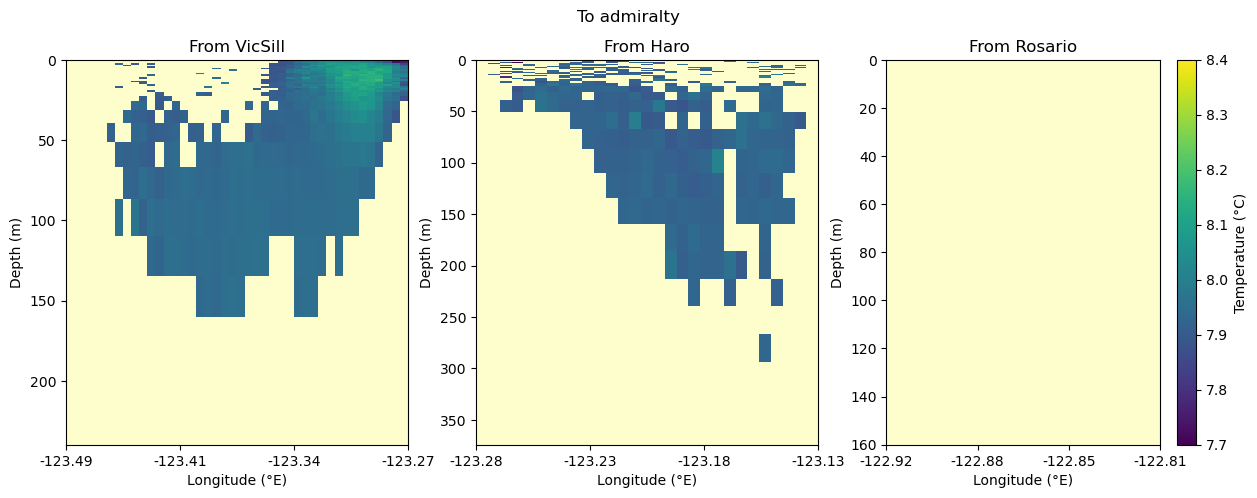

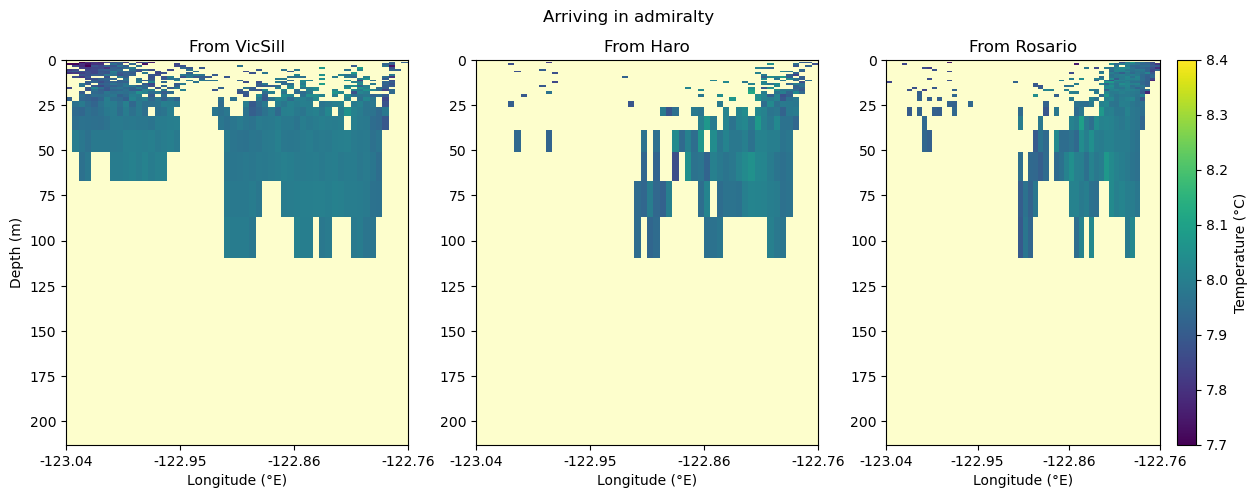

In [51]:
title = 'From VicSill'
title2 = 'From Haro'
title3 = 'From Rosario'

tmin = 7.7
tmax = 8.4

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'temp',vsbas['final_lon'],vsbas['final_z'],vsbas['final_temp'],lonWvs,lonEvs,33,timeb,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'temp',harobas['final_lon'],harobas['final_z'],harobas['final_temp'],lonWharo,lonEharo,38,timeb,title2,False,True,vmin=tmin,vmax=tmax)
plotTS(ax3,'temp',rosbas['final_lon'],rosbas['final_z'],rosbas['final_temp'],lonWros,lonEros,30,timeb,title3,True,True,vmin=tmin,vmax=tmax)
fig.suptitle('To admiralty')

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'temp',admfvs['final_lon'],admfvs['final_z'],admfvs['final_temp'],lonWadm,lonEadm,32,time,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'temp',admfhsvs['final_lon'],admfhsvs['final_z'],admfhsvs['final_temp'],lonWadm,lonEadm,32,time,title2,False,False,vmin=tmin,vmax=tmax)
plotTS(ax3,'temp',admfrsvs['final_lon'],admfrsvs['final_z'],admfrsvs['final_temp'],lonWadm,lonEadm,32,time,title3,True,False,vmin=tmin,vmax=tmax)
fig.suptitle('Arriving in admiralty')

/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'Arriving in admiralty')

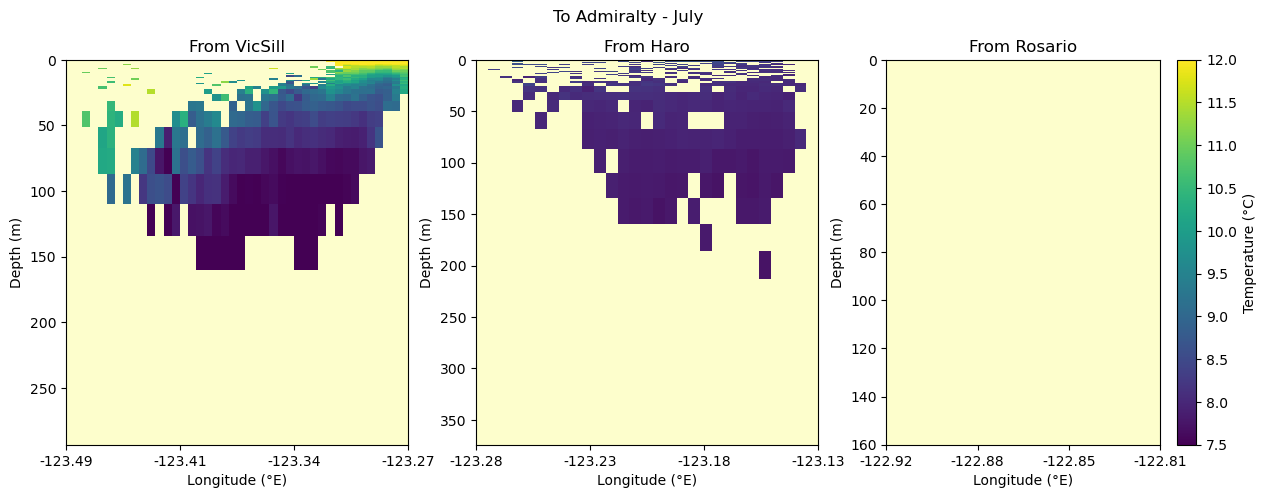

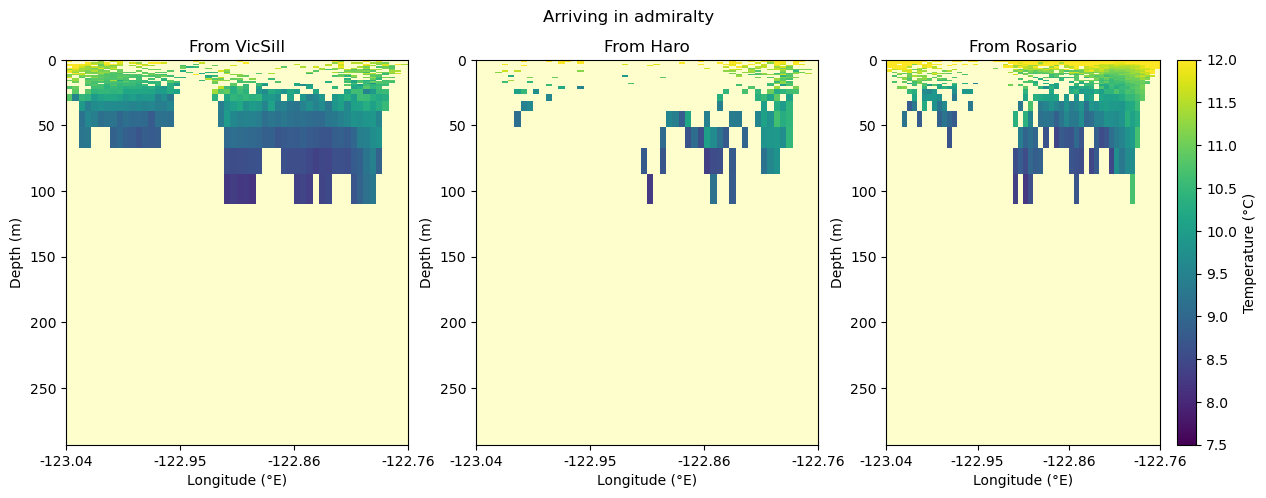

In [52]:
title = 'From VicSill'
title2 = 'From Haro'
title3 = 'From Rosario'

tmin = 7.5
tmax = 12

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'temp',vsbas07['final_lon'],vsbas07['final_z'],vsbas07['final_temp'],lonWvs,lonEvs,35,time,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'temp',harobas07['final_lon'],harobas07['final_z'],harobas07['final_temp'],lonWharo,lonEharo,38,time,title2,False,True,vmin=tmin,vmax=smax)
plotTS(ax3,'temp',rosbas07['final_lon'],rosbas07['final_z'],rosbas07['final_temp'],lonWros,lonEros,30,time,title3,True,True,vmin=tmin,vmax=tmax)
fig.suptitle('To Admiralty - July')

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'temp',admfvs07['final_lon'],admfvs07['final_z'],admfvs07['final_temp'],lonWadm,lonEadm,35,time,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'temp',admfhs07['final_lon'],admfhs07['final_z'],admfhs07['final_temp'],lonWadm,lonEadm,35,time,title2,False,True,vmin=tmin,vmax=tmax)
plotTS(ax3,'temp',admfrs07['final_lon'],admfrs07['final_z'],admfrs07['final_temp'],lonWadm,lonEadm,35,time,title3,True,True,vmin=tmin,vmax=tmax)
fig.suptitle('Arriving in admiralty')

Temperature still low in Haro???

### Backwards Victoria Sill

/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/

Text(0.5, 0.98, 'VicSill - July')

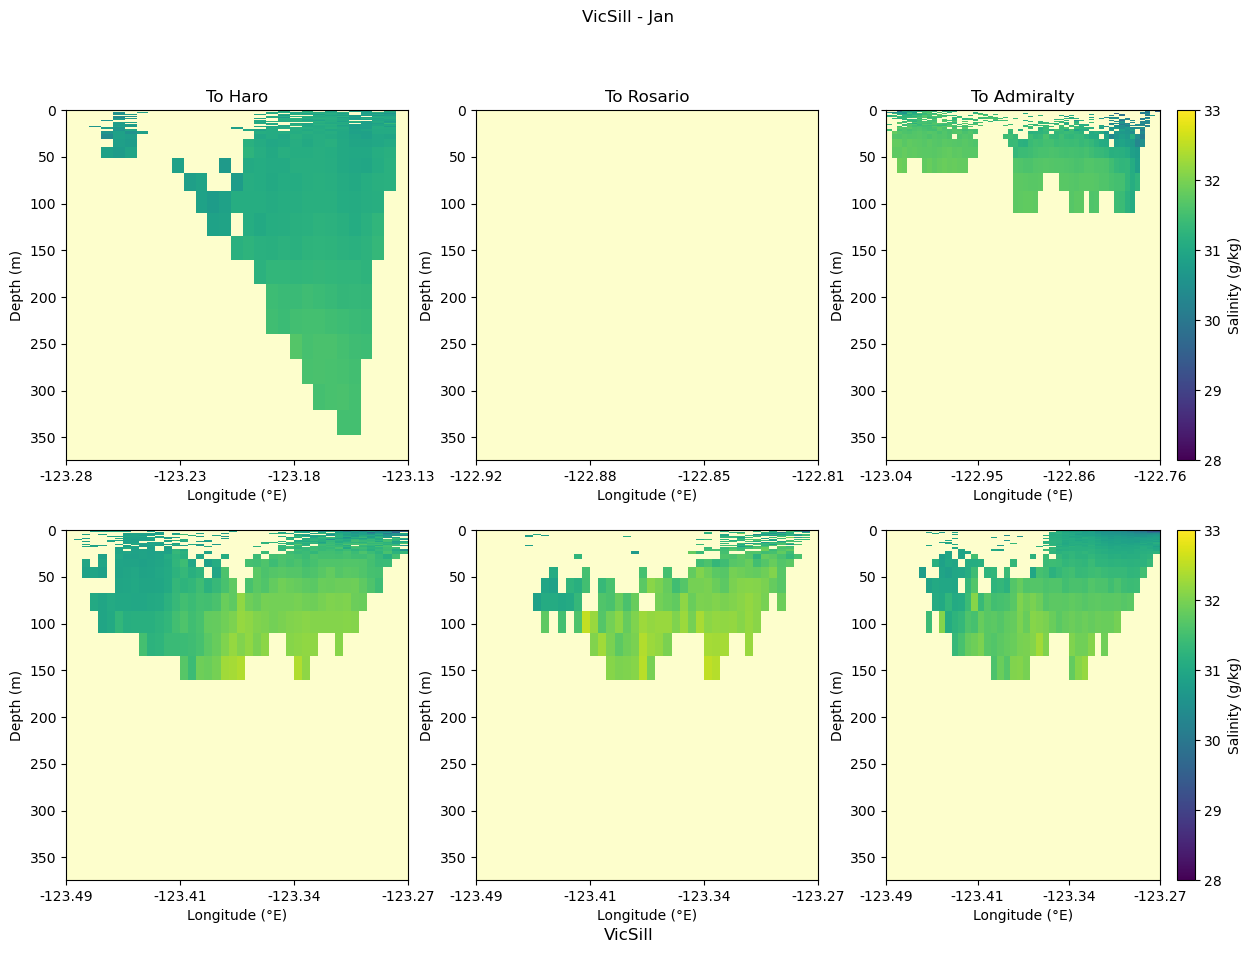

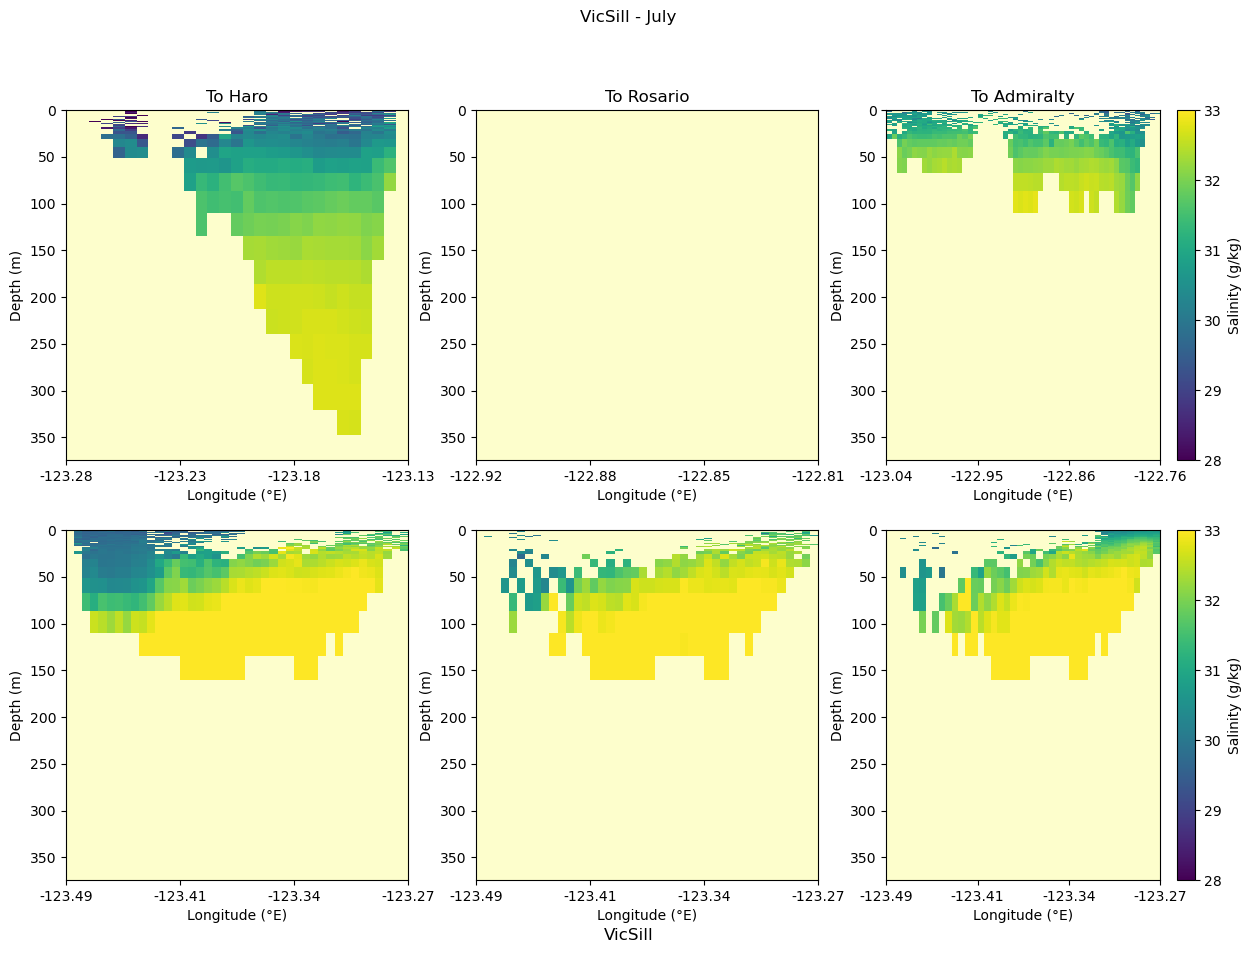

In [53]:
harobvs = get_secdata(databvs,6)
rosbvs = get_secdata(databvs,4)
sjcbvs = get_secdata(databvs,5)
admbvs = get_secdata(databvs,2)
harobvs07 = get_secdata(databvs07,6)
rosbvs07 = get_secdata(databvs07,4)
sjcbvs07 = get_secdata(databvs07,5)
admbvs07 = get_secdata(databvs07,2)

vsbhs = get_secdata(databhsvs,6)
vsbrs = get_secdata(databrsvs,4)
vsbas07 = get_secdata(databas07,2)
vsbhs07 = get_secdata(databhsvs07,6)
vsbrs07 = get_secdata(databrsvs07,4)
rosfvs = get_secdata(databvs,4)
rosfvs07 = get_secdata(databvs07,4)

tmin = 28
tmax = 33

title = 'To Haro'
title2 = 'To Rosario'
title3 = 'To Admiralty'

fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3,figsize=(15,10))

plotTS(ax1,'sal',harofvs['final_lon'],harofvs['final_z'],harofvs['final_salt'],lonWharo,lonEharo,38,time,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'sal',rosfvs['final_lon'],rosfvs['final_z'],rosfvs['final_salt'],lonWros,lonEros,38,time,title2,False,True,vmin=tmin,vmax=tmax)
plotTS(ax3,'sal',admfvs['final_lon'],admfvs['final_z'],admfvs['final_salt'],lonWadm,lonEadm,38,time,title3,True,True,vmin=tmin,vmax=tmax)
fig.suptitle('VicSill - Jan')
fig.text(0.5, 0.05, 'VicSill', ha='center', fontsize=12)
plotTS(ax4,'sal',vsbhs['final_lon'],vsbhs['final_z'],vsbhs['final_salt'],lonWvs,lonEvs,38,time,'',False,True,vmin=tmin,vmax=tmax)
plotTS(ax5,'sal',vsbrs['final_lon'],vsbrs['final_z'],vsbrs['final_salt'],lonWvs,lonEvs,38,time,'',False,True,vmin=tmin,vmax=tmax)
plotTS(ax6,'sal',vsbas['final_lon'],vsbas['final_z'],vsbas['final_salt'],lonWvs,lonEvs,38,time,'',True,True,vmin=tmin,vmax=tmax)

fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3,figsize=(15,10))

plotTS(ax1,'sal',harofvs07['final_lon'],harofvs07['final_z'],harofvs07['final_salt'],lonWharo,lonEharo,38,time,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'sal',rosfvs07['final_lon'],rosfvs07['final_z'],rosfvs07['final_salt'],lonWros,lonEros,38,time,title2,False,True,vmin=tmin,vmax=tmax)
plotTS(ax3,'sal',admfvs07['final_lon'],admfvs07['final_z'],admfvs07['final_salt'],lonWadm,lonEadm,38,time,title3,True,True,vmin=tmin,vmax=tmax)

plotTS(ax4,'sal',vsbhs07['final_lon'],vsbhs07['final_z'],vsbhs07['final_salt'],lonWvs,lonEvs,38,time,'',False,True,vmin=tmin,vmax=tmax)
plotTS(ax5,'sal',vsbrs07['final_lon'],vsbrs07['final_z'],vsbrs07['final_salt'],lonWvs,lonEvs,38,time,'',False,True,vmin=tmin,vmax=tmax)
plotTS(ax6,'sal',vsbas07['final_lon'],vsbas07['final_z'],vsbas07['final_salt'],lonWvs,lonEvs,38,time,'',True,True,vmin=tmin,vmax=tmax)
fig.text(0.5, 0.05, 'VicSill', ha='center', fontsize=12)
fig.suptitle('VicSill - July')

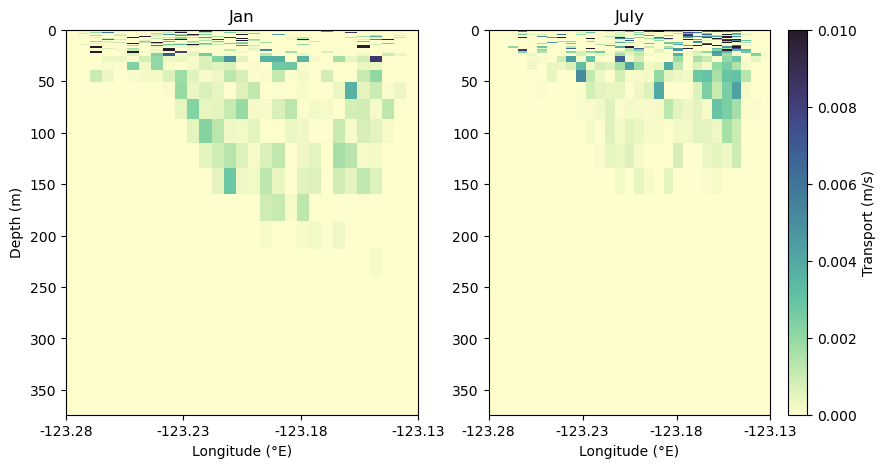

In [54]:
# Compare from Haro, S/W transport

title = 'Jan'
title2 = 'July'

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

vmax=0.01

plotCS(ax1,harobas['final_lon'],harobas['final_z'],harobas['final_transp'],lonWharo,lonEharo,38,vmax,time,title,False,True)
plotCS(ax2,harobas07['final_lon'],harobas07['final_z'],harobas07['final_transp'],lonWharo,lonEharo,38,vmax,time,title2,True,False)

### Properties to PR

/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.05, 'Arriving in Point Roberts')

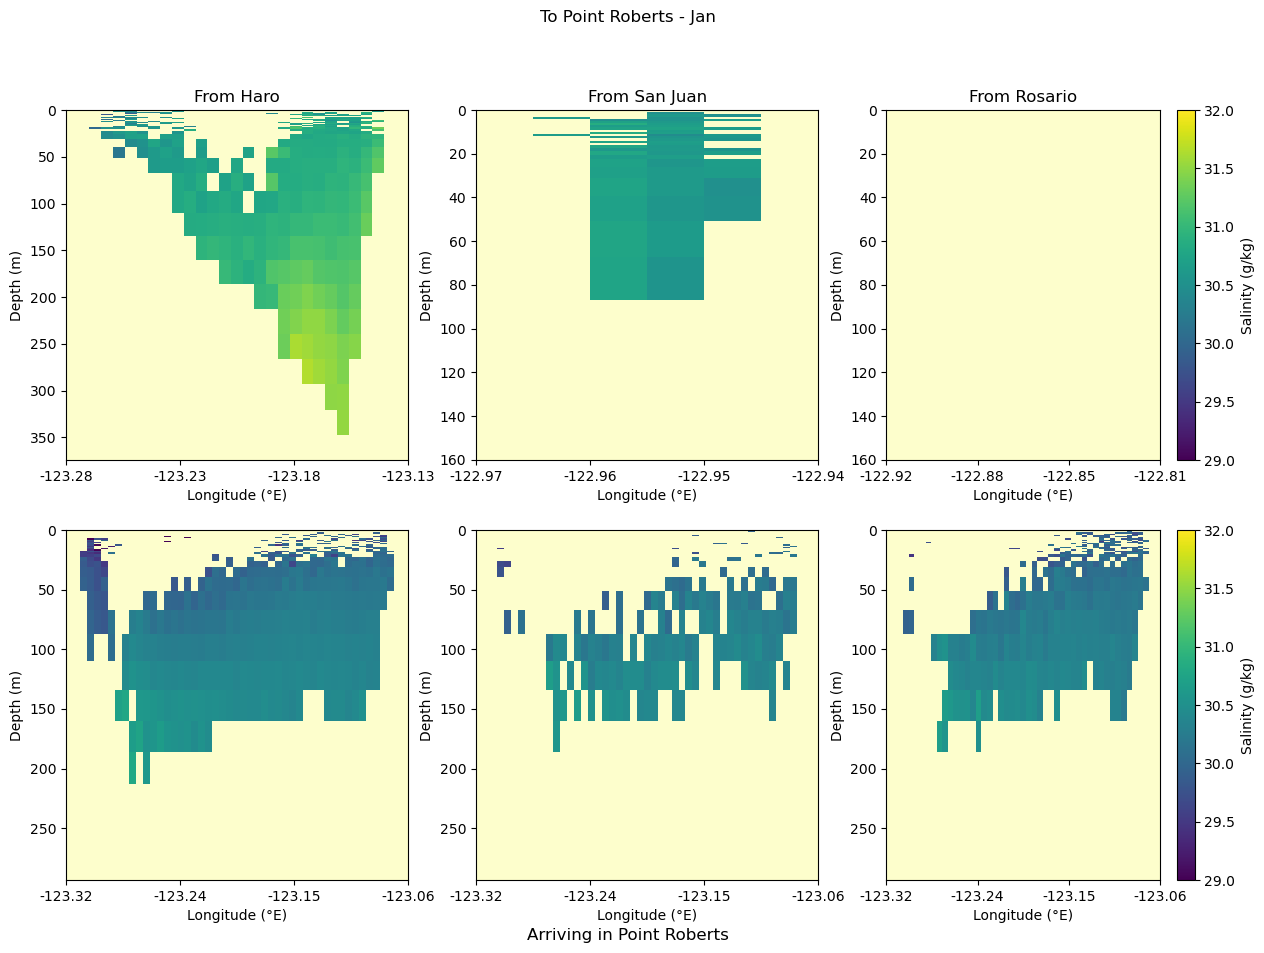

In [56]:
harobpr = get_secdata(data_dict['databpr'],6)
prfhs = get_secdata(data_dict['datafhspr'],6)
rosbpr = get_secdata(data_dict['databpr'],4)
prfrs = get_secdata(data_dict['datafrspr'],4)
sjcbpr = get_secdata(data_dict['databpr'],5)
prfsj = get_secdata(data_dict['datafsjpr'],5)

title = 'From Haro'
title2 = 'From San Juan'
title3 = 'From Rosario'

lonWsjc = 274
lonEsjc = 281
lonWpr = 207
lonEpr = 257

fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3,figsize=(15,10))

plotTS(ax1,'sal',harobpr['final_lon'],harobpr['final_z'],harobpr['final_salt'],lonWharo,lonEharo,38,time,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',sjcbpr['final_lon'],sjcbpr['final_z'],sjcbpr['final_salt'],lonWsjc,lonEsjc,30,time,title2,False,True,vmin=smin,vmax=smax)
plotTS(ax3,'sal',rosbpr['final_lon'],rosbpr['final_z'],rosbpr['final_salt'],lonWros,lonEros,30,time,title3,True,True,vmin=smin,vmax=smax)
fig.suptitle('To Point Roberts - Jan')

plotTS(ax4,'sal',prfhs['final_lon'],prfhs['final_z'],prfhs['final_salt'],lonWpr,lonEpr,35,time,'',False,True,vmin=smin,vmax=smax)
plotTS(ax5,'sal',prfsj['final_lon'],prfsj['final_z'],prfsj['final_salt'],lonWpr,lonEpr,35,time,'',False,True,vmin=smin,vmax=smax)
plotTS(ax6,'sal',prfrs['final_lon'],prfrs['final_z'],prfrs['final_salt'],lonWpr,lonEpr,35,time,'',True,True,vmin=smin,vmax=smax)

fig.text(0.5, 0.05, 'Arriving in Point Roberts', ha='center', fontsize=12)

/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_28627/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.05, 'Arriving in Point Roberts')

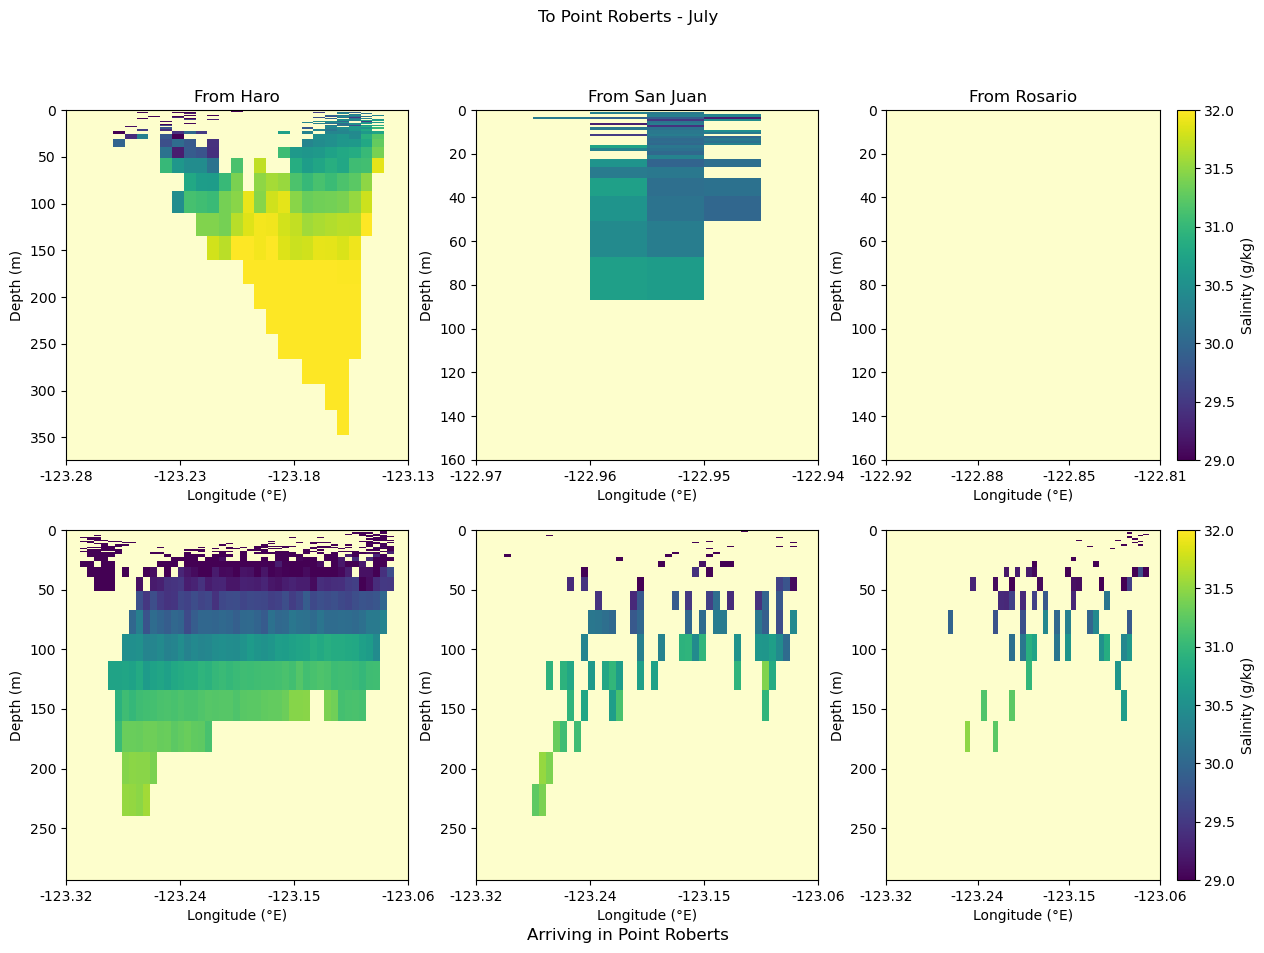

In [57]:
harobpr07 = get_secdata(data_dict['databpr07'],6)
sjcbpr07 = get_secdata(data_dict['databpr07'],5)
rosbpr07 = get_secdata(data_dict['databpr07'],4)
prfhs07 = get_secdata(data_dict['datafhspr07'],6)
prfrs07 = get_secdata(data_dict['datafrspr07'],4)
prfsj07 = get_secdata(data_dict['datafsjpr07'],5)

fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3,figsize=(15,10))

plotTS(ax1,'sal',harobpr07['final_lon'],harobpr07['final_z'],harobpr07['final_salt'],lonWharo,lonEharo,38,time,title,False,True,vmin=smin,vmax=smax)
plotTS(ax3,'sal',rosbpr07['final_lon'],rosbpr07['final_z'],rosbpr07['final_salt'],lonWros,lonEros,30,time,title3,True,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',sjcbpr07['final_lon'],sjcbpr07['final_z'],sjcbpr07['final_salt'],lonWsjc,lonEsjc,30,time,title2,False,True,vmin=smin,vmax=smax)

plotTS(ax4,'sal',prfhs07['final_lon'],prfhs07['final_z'],prfhs07['final_salt'],lonWpr,lonEpr,35,time,'',False,True,vmin=smin,vmax=smax)
plotTS(ax6,'sal',prfrs07['final_lon'],prfrs07['final_z'],prfrs07['final_salt'],lonWpr,lonEpr,35,time,'',True,True,vmin=smin,vmax=smax)
plotTS(ax5,'sal',prfsj07['final_lon'],prfsj07['final_z'],prfsj07['final_salt'],lonWpr,lonEpr,35,time,'',False,True,vmin=smin,vmax=smax)

fig.suptitle('To Point Roberts - July')
fig.text(0.5, 0.05, 'Arriving in Point Roberts', ha='center', fontsize=12)